In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

from eqflow.nsf import NeuralSplineFlow
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

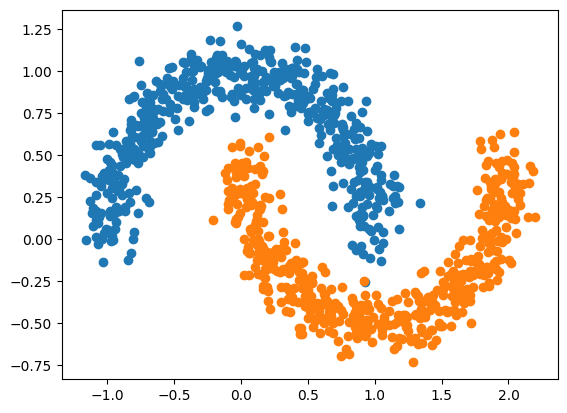

In [2]:
xy, labels = make_moons(n_samples=1000, noise=0.1, random_state=0)
x, y = xy[:,0], xy[:,1]
x, y = jnp.asarray(x), jnp.asarray(y)
plt.scatter(x[labels == 0], y[labels == 0])
plt.scatter(x[labels == 1], y[labels == 1])

In [3]:
rng = jax.random.PRNGKey(0)

# Joint distribution

In [4]:
nsf = NeuralSplineFlow(rng, n_dim=2, n_context=0, n_transforms=8, n_bins=16, spline_min=-5., spline_max=5.0)
optimizer = optax.adam(2e-3)
opt_state = optimizer.init(eqx.filter(nsf, eqx.is_array))

In [5]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_fn(model, xy):
    return -jax.vmap(model.log_prob)(xy).sum()

@eqx.filter_jit
def step(model, opt_state, xy):
    loss_value, grads = loss_fn(model, xy)
    updates, opt_state = optimizer.update(
        grads, opt_state, model
    )
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

In [6]:
losses = []
xy = jnp.stack((x, y)).T
for e in (pbar := tqdm(range(5000))):
    nsf, opt_state, loss_value = step(nsf, opt_state, xy)
    losses.append(loss_value)
    if e % 100 == 0:
        pbar.set_description(f"loss: {loss_value:.3f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

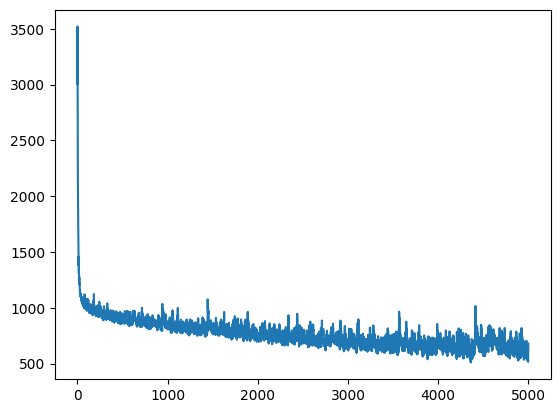

In [7]:
plt.plot(losses)

In [8]:
xgrid = jnp.linspace(-1.5, 2.5)
ygrid = jnp.linspace(-1.5, 2.5)
xx, yy = jnp.meshgrid(xgrid, ygrid)
xx, yy = xx.flatten(), yy.flatten()
xxyy = jnp.stack((xx, yy)).T
lp = jax.vmap(nsf.log_prob)(xxyy)

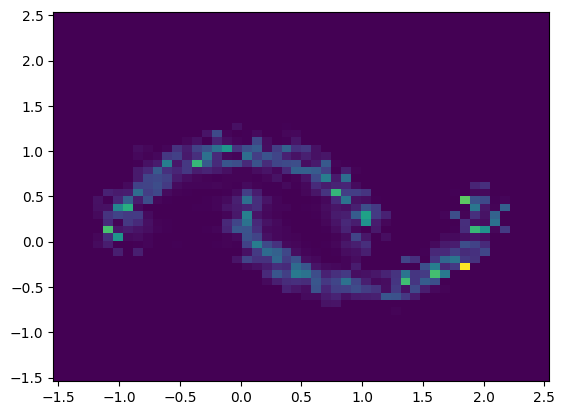

In [9]:
plt.pcolormesh(xx.reshape(50, 50), yy.reshape(50, 50), jnp.exp(lp.reshape(50, 50)))

# Conditional distribution

In [4]:
nsf = NeuralSplineFlow(rng, n_dim=1, n_context=1, n_transforms=8, n_bins=16, spline_min=-5., spline_max=5.0)
optimizer = optax.adam(2e-3)
opt_state = optimizer.init(eqx.filter(nsf, eqx.is_array))

In [5]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_fn(model, x, y):
    return -jax.vmap(model.log_prob)(x, context=y).sum()

@eqx.filter_jit
def step(model, opt_state, x, y):
    loss_value, grads = loss_fn(model, x, y)
    updates, opt_state = optimizer.update(
        grads, opt_state, model
    )
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

In [6]:
losses = []
for e in (pbar := tqdm(range(5000))):
    nsf, opt_state, loss_value = step(nsf, opt_state, x, y)
    losses.append(loss_value)
    if e % 100 == 0:
        pbar.set_description(f"loss: {loss_value:.3f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

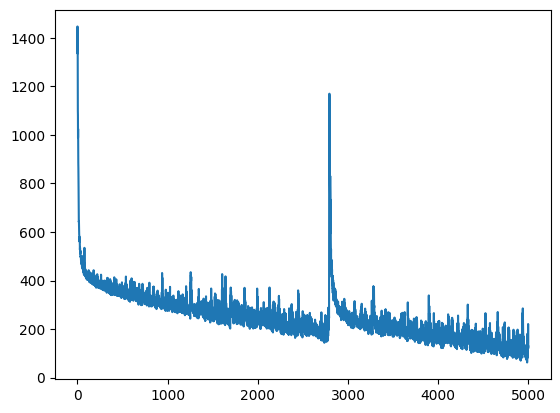

In [7]:
plt.plot(losses)

In [8]:
xgrid = jnp.linspace(-1.5, 2.5)
ygrid = jnp.linspace(-1.5, 2.5)
xx, yy = jnp.meshgrid(xgrid, ygrid)
xx, yy = xx.flatten(), yy.flatten()
lp = jax.vmap(nsf.log_prob)(xx, context=yy)

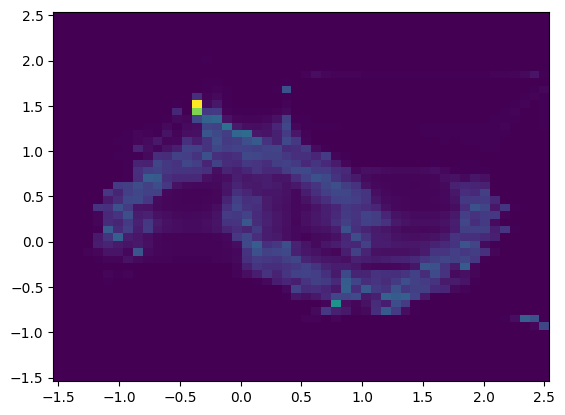

In [21]:
plt.pcolormesh(xx.reshape(50, 50), yy.reshape(50, 50), 1.5**lp.reshape(50, 50))